In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob

In [2]:
raw_dat_dir = '/home/grace/Documents/python/acute_oral/data/raw/'
processed_dat_dir = '/home/grace/Documents/python/acute_oral/data/processed/'
interim_dat_dir = '/home/grace/Documents/python/acute_oral/data/interim/'
figures_dir = '/home/grace/Documents/python/acute_oral/reports/figures/'
test_dir = '/home/grace/Documents/python/acute_oral/data/external/TEST/'
times_dir = '/home/grace/Documents/python/acute_oral/data/external/TIMES/'

In [3]:
xls = pd.ExcelFile(processed_dat_dir+'relevant_acute_pred_final_200320.xlsx')

In [4]:
xls.sheet_names

['relevant_pred']

In [5]:
relevant_acute_data = xls.parse('relevant_pred')

In [6]:
relevant_acute_data.shape

(8979, 32)

In [8]:
relevant_acute_data[(relevant_acute_data['TEST_LD50_mgkg'].isnull()) & (~relevant_acute_data['TEST_pLD50'].isnull()) ]

,Unnamed: 0,DTXSID,CAS,name,known_LD50_mgkg,known_pLD50,TEST_LD50_mgkg,TEST_pLD50,TIMES_LD50_mgkg,TIMES_pLD50,...,molecular_initiating_event_3,effect_biological outcome_3,alert_reliability,parameter_ranges,correct_fragments_structural_domain,incorrect_fragments_structural_domain,unknown_fragments_structural_domain,total_structural_domain,total_domain,acute_oral_toxicity_confidence
3667,3667,NaN,29387-86-8,NaN,1900.0,NaN,NaN,1.29,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4639,4639,NaN,39699-08-6,NaN,29000.0,NaN,NaN,1.30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
chemotypes = pd.read_csv(raw_dat_dir+'Acute_SMILES_Toxprints.tsv', sep = '\t')

In [10]:
chemotypes.rename(columns = {'M_NAME': 'CAS'}, inplace = True)

In [11]:
for_enrich = relevant_acute_data[['DTXSID', 'CAS', 'name', 'known_LD50_mgkg', 'known_pLD50',
       'TEST_LD50_mgkg', 'TEST_pLD50', 'TIMES_LD50_mgkg', 'TIMES_pLD50',
       'TIMES', 'TEST', 'known_pLD50_minus_TEST', 'known_pLD50_minus_TIMES',
       'average_mass', 'qsar_ready_smiles', 'smiles']]

In [12]:
for_enrich.shape

(8979, 16)

In [13]:
for_enrich_txps = pd.merge(for_enrich, chemotypes, on = 'CAS', how = 'left')

In [14]:
TEST_for_enrich = for_enrich_txps[(~for_enrich_txps['TEST'].isnull())]

In [15]:
TIMES_for_enrich = for_enrich_txps[(~for_enrich_txps['TIMES'].isnull())]

In [16]:
TEST_for_enrich['TEST_out_CI'] = TEST_for_enrich['TEST'].apply(lambda x: 0 if x == 'Within_CI' else 1)

/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
TIMES_for_enrich['TIMES_out_CI'] = TIMES_for_enrich['TIMES'].apply(lambda x: 0 if x == 'Within_CI' else 1)

/home/grace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
TIMES_for_enrich = TIMES_for_enrich.set_index('DTXSID')
TEST_for_enrich = TEST_for_enrich.set_index('DTXSID')

In [19]:
TIMES_for_enrich.columns.get_loc('atom:element_main_group')
TEST_for_enrich.columns.get_loc('atom:element_main_group')

15

In [20]:
import scipy.stats as stats

In [144]:
res_TEST = []
for i, column in TEST_for_enrich.iloc[:,15:-1].iteritems():
    if pd.crosstab(TEST_for_enrich.iloc[:,744],column).shape == (2,2):
        a = pd.crosstab(TEST_for_enrich.iloc[:,744],column)
        tn, fn, fp, tp = a.iloc[0,0], a.iloc[0,1], a.iloc[1,0], a.iloc[1,1]
        #tested_active = (tp + fn)
        oddsratio, pvalue = stats.fisher_exact(a)
        res_TEST.append([oddsratio, pvalue, i, tp, fn, fp, tn])


In [145]:
res_TIMES = []
for i, column in TIMES_for_enrich.iloc[:,15:-1].iteritems():
    if pd.crosstab(TIMES_for_enrich.iloc[:,744],column).shape == (2,2):
        a = pd.crosstab(TIMES_for_enrich.iloc[:,744],column)
        tn, fn, fp, tp = a.iloc[0,0], a.iloc[0,1], a.iloc[1,0], a.iloc[1,1]
        #tested_active = (tp + fn)
        oddsratio, pvalue = stats.fisher_exact(a)
        res_TIMES.append([oddsratio, pvalue, i, tp, fn, fp, tn])

In [146]:
def convert(lst):
    df = pd.DataFrame(lst)
    df.rename(columns = {0: 'OR', 1: 'p', 2 : 'TxP', 3: 'TP', 4: 'FN', 5: 'FP', 6: 'TN'}, inplace = True)
    df = df.sort_values(by=['OR','p'], ascending = [True, False])
    return df

In [147]:
TEST_enrichments = convert(res_TEST)
TIMES_enrichments = convert(res_TIMES)

In [148]:
pd.crosstab(TEST_for_enrich.iloc[:,744],TEST_for_enrich.loc[:,'bond:C(=O)O_carboxylicEster_thio'])

bond:C(=O)O_carboxylicEster_thio,0.0,1.0
TEST_out_CI,,
0,585,3
1,1031,0


In [149]:
pd.crosstab(TEST_for_enrich.iloc[:,744],TEST_for_enrich.loc[:,'bond:CC(=O)C_ketone_alkene_cyclic_2-en-1-one'])

bond:CC(=O)C_ketone_alkene_cyclic_2-en-1-one,0.0,1.0
TEST_out_CI,,
0,581,7
1,1000,31


In [150]:
TEST_enriched = TEST_enrichments[(TEST_enrichments['OR'] >= 2.5) & (TEST_enrichments['p'] < 0.05 ) & (TEST_enrichments['TP'] >=3)]

In [151]:
TEST_enriched

,OR,p,TxP,TP,FN,FP,TN
54,2.573000,0.025145,bond:CC(=O)C_ketone_alkene_cyclic_2-en-1-one,31,7,1000,581
207,4.251734,0.010707,bond:S(=O)N_sulfonamide,22,3,1009,585
226,4.375624,0.001863,bond:S~N_generic,30,4,1001,584
208,5.044776,0.002795,bond:S(=O)N_sulfonylamide,26,3,1005,585
434,12.204950,0.001140,ring:hetero_[6_6]_O_benzopyrone_(1_4-),21,1,1010,587


In [152]:
def ci_devel(df):
    ci_upper = []
    ci_lower = []

    for i, row in df.iterrows():
        ln_OR = np.log(row['OR'])
        #print(ln_OR)
        SE_ln_OR = sqrt((1/row['TP']) + (1/row['FN'])+(1/row['FP'])+(1/row['TN']))
        #print(SE_ln_OR)
        ln_CI_upper = ln_OR+(1.96*SE_ln_OR)
        ln_CI_lower = ln_OR-(1.96*SE_ln_OR)
        CI_upper = np.exp(ln_CI_upper)
        CI_lower = np.exp(ln_CI_lower)
        ci_upper.append(CI_upper)
        ci_lower.append(CI_lower)   
    return ci_lower, ci_upper

In [153]:
ci_devel(TEST_enriched)

([1.1258381497027883,
  1.2671091020380474,
  1.5338480033349087,
  1.520295705841139,
  1.6374501348957966],
 [5.880355894626337,
  14.26652629845555,
  12.482389803246848,
  16.74001051053286,
  90.97120786282055])

In [154]:
((1/31) + (1/1000)+(1/7)+(1/581))**0.5

0.42170650667157256

In [155]:
from math import sqrt

In [156]:
sqrt((1/31) + (1/7)+(1/1000)+(1/581))

0.42170650667157256

In [157]:
TIMES_enriched = TIMES_enrichments[(TIMES_enrichments['OR'] >= 2.5) & (TIMES_enrichments['p'] < 0.05 ) & (TIMES_enrichments['TP'] >=3)]

In [158]:
TIMES_enriched 

,OR,p,TxP,TP,FN,FP,TN
144,3.280142,0.006806,bond:quatN_alkyl_acyclic,30,6,282,185
146,3.523810,0.002877,bond:quatN_generic,32,6,280,185
147,4.063709,0.022398,bond:quatN_trimethyl_alkyl_acyclic,19,3,293,188
240,6.943522,0.035363,group:ligand_path_5-7_bidentate,11,1,301,190
68,inf,0.026908,bond:COH_alcohol_allyl,8,0,304,191
65,inf,0.015381,bond:COC_ether_alkenyl,9,0,303,191


In [159]:
def ci_devel(df):
    ci_upper = []
    ci_lower = []

    for i, row in df.iterrows():
        if row['OR'] != np.inf:
            ln_OR = np.log(row['OR'])
        #except ZeroDivisionError as error:
        #   print(error)
        #else:
            SE_ln_OR = sqrt((1/row['TP']) + (1/row['FN'])+(1/row['FP'])+(1/row['TN']))
            #print(SE_ln_OR)
            ln_CI_upper = ln_OR+(1.96*SE_ln_OR)
            ln_CI_lower = ln_OR-(1.96*SE_ln_OR)
            CI_upper = np.exp(ln_CI_upper)
            CI_lower = np.exp(ln_CI_lower)
            ci_upper.append(CI_upper)
            ci_lower.append(CI_lower)   
    return ci_lower, ci_upper

In [160]:
ci_devel(TIMES_enriched)


([1.3390318869187512,
  1.444879504002865,
  1.1861676571494222,
  0.8892437651688527],
 [8.035156310826867, 8.593957853018368, 13.921918024148797, 54.21740812171299])

In [161]:
TIMES_enrichments['Model'] = 'TIMES'

In [190]:
TEST_enrichments

,OR,p,TxP,TP,FN,FP,TN,Model
11,0.0,0.363187,bond:C(~Z)~C~Q_haloether_dibenzodioxin_1-halo,0,1,1031,587,TEST
12,0.0,0.363187,bond:C(~Z)~C~Q_haloether_dibenzodioxin_2-halo,0,1,1031,587,TEST
13,0.0,0.363187,bond:C(~Z)~C~Q_haloether_dibenzodioxin_dichlor...,0,1,1031,587,TEST
14,0.0,0.363187,bond:C(~Z)~C~Q_haloether_dibenzodioxin_tetrach...,0,1,1031,587,TEST
66,0.0,0.363187,bond:CN_amine_alkyl_methanolamine,0,1,1031,587,TEST
...,...,...,...,...,...,...,...,...
132,inf,0.165784,bond:CX_halide_alkyl-X_tertiary,5,0,1026,588,TEST
216,inf,0.165784,bond:S(=O)O_sulfonicEster_alkyl_O-C_(H=0),5,0,1026,588,TEST
154,inf,0.092554,bond:CX_halide_aromatic-X_trihalo_benzene_(1_3...,6,0,1025,588,TEST
214,inf,0.092554,bond:S(=O)O_sulfonicEster_acyclic_S-C_(chain),6,0,1025,588,TEST


In [178]:
#for i, row in TIMES_enrichments.iterrows():
#    print(row['FN']/(row['TN'] + row['TN']))

In [191]:
def prob_deriv(df):
    ppv_all = []
    false_or_all = []
    txps = []
    
    for i, row in df.iterrows():
        ppv = row['TP']/(row['TP'] + row['FP'])
        false_or = row['FN']/(row['FN'] + row['TN'])
        ppv_all.append(ppv)
        false_or_all.append(false_or)
        txps.append(row['TxP'])
    return txps, ppv_all, false_or_all

In [192]:
prob_TIMES = prob_deriv(TIMES_enrichments)

In [193]:
prob_TEST = prob_deriv(TEST_enrichments)

In [200]:
prob_TEST_df = pd.DataFrame(prob_TEST).T

In [201]:
prob_TEST_df.columns = ['TxP', 'PPV', 'FOR']

In [204]:
prob_TEST_df['Model'] = 'TEST'

In [205]:
prob_TIMES_df = pd.DataFrame(prob_TIMES).T
prob_TIMES_df.columns = ['TxP', 'PPV', 'FOR']
prob_TIMES_df['Model'] = 'TIMES'

In [208]:
prob_TEST_df

,TxP,PPV,FOR,Model
0,bond:C(~Z)~C~Q_haloether_dibenzodioxin_1-halo,0,0.00170068,TEST
1,bond:C(~Z)~C~Q_haloether_dibenzodioxin_2-halo,0,0.00170068,TEST
2,bond:C(~Z)~C~Q_haloether_dibenzodioxin_dichlor...,0,0.00170068,TEST
3,bond:C(~Z)~C~Q_haloether_dibenzodioxin_tetrach...,0,0.00170068,TEST
4,bond:CN_amine_alkyl_methanolamine,0,0.00170068,TEST
...,...,...,...,...
449,bond:CX_halide_alkyl-X_tertiary,0.00484966,0,TEST
450,bond:S(=O)O_sulfonicEster_alkyl_O-C_(H=0),0.00484966,0,TEST
451,bond:CX_halide_aromatic-X_trihalo_benzene_(1_3...,0.00581959,0,TEST
452,bond:S(=O)O_sulfonicEster_acyclic_S-C_(chain),0.00581959,0,TEST


In [209]:
all_probs = pd.concat([prob_TEST_df,prob_TIMES_df])

In [236]:
all_probs.to_csv(interim_dat_dir+'all_probs.csv')

In [234]:
all_probs.Model.unique()

array(['TEST', 'TIMES'], dtype=object)

(array([649.,  66.,  20.,  21.,   4.,   6.,   2.,   2.,   0.,   2.]),
 array([0.0, 0.06282051282051282, 0.12564102564102564, 0.18846153846153846,
        0.2512820512820513, 0.3141025641025641, 0.3769230769230769,
        0.43974358974358974, 0.5025641025641026, 0.5653846153846154,
        0.6282051282051282], dtype=object),
 <a list of 10 Patch objects>)

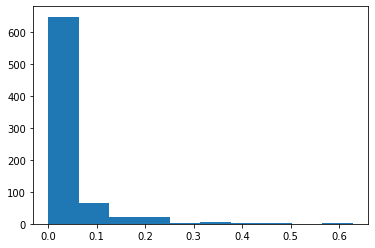

In [220]:
plt.hist(all_probs['PPV'])

In [239]:
pivot_probs = pd.pivot(all_probs, index = 'TxP', columns = 'Model' , values = 'PPV')

In [241]:
pivot_probs.to_csv(interim_dat_dir+'all_pivot_probs.csv')

In [162]:
TEST_enrichments['Model'] = 'TEST'

In [163]:
all_enrichments = pd.concat([TIMES_enrichments,TEST_enrichments])

In [164]:
all_enrichments.to_csv(interim_dat_dir+'all_enrichments.csv')

In [216]:
all_enrichments

,OR,p,TxP,TP,FN,FP,TN,Model
36,0.0,0.379722,bond:CC(=O)C_ketone_alkane_cyclic_(C5),0,1,312,190,TIMES
115,0.0,0.379722,bond:CX_halide_aromatic-X_ether_aromatic_(Ph-O...,0,1,312,190,TIMES
139,0.0,0.379722,bond:P=O_phosphate_thioate,0,1,312,190,TIMES
143,0.0,0.379722,bond:QQ(Q~O_S)_sulfur_oxide,0,1,312,190,TIMES
153,0.0,0.379722,bond:S(=O)O_sulfonicEster_acyclic_(S-C(ring)),0,1,312,190,TIMES
...,...,...,...,...,...,...,...,...
132,inf,0.165784,bond:CX_halide_alkyl-X_tertiary,5,0,1026,588,TEST
216,inf,0.165784,bond:S(=O)O_sulfonicEster_alkyl_O-C_(H=0),5,0,1026,588,TEST
154,inf,0.092554,bond:CX_halide_aromatic-X_trihalo_benzene_(1_3...,6,0,1025,588,TEST
214,inf,0.092554,bond:S(=O)O_sulfonicEster_acyclic_S-C_(chain),6,0,1025,588,TEST


In [165]:
enrich_pivot = pd.pivot_table(index = 'TxP', columns = 'Model', values = ['OR', 'p'], data = all_enrichments)

In [166]:
enrich_pivot

OR              p          
Model                                       TEST     TIMES TEST     TIMES
TxP                                                                      
atom:element_metal_metalloid            1.026810  2.467532  1.0  0.654153
bond:C#N_cyano_acylcyanide                   inf       inf  1.0  1.000000
bond:C#N_cyano_cyanamide                0.569903       NaN  1.0       NaN
bond:C#N_nitrile                        0.969034       inf  1.0  0.087484
bond:C#N_nitrile_ab-unsaturated         1.713035       NaN  1.0       NaN
...                                          ...       ...  ...       ...
ring:polycycle_bicyclo_[3.2.1]octane         inf       NaN  1.0       NaN
ring:polycycle_bicyclo_[3.3.1]nonane    0.569903  0.000000  1.0  0.379722
ring:polycycle_bicyclo_[4.3.1]decane         inf       NaN  1.0       NaN
ring:polycycle_bicyclo_[4.4.1]undecane       inf       NaN  1.0       NaN
ring:polycycle_tricyclo_adamantane      0.569903  0.000000  1.0  0.379722

[459 rows x 4 columns]

In [141]:
enrich_pivot[(~enrich_pivot['OR','TEST'].isnull()) & (~enrich_pivot['OR','TIMES'].isnull()) ].to_csv(interim_dat_dir+'enrich_pivot.csv')

In [38]:
#TIMES_for_enrich
mask = (TEST_for_enrich['bond:S(=O)N_sulfonamide'] == 1) | (TEST_for_enrich['bond:S(=O)N_sulfonamide'] == 1)

In [39]:
specific_txps = TEST_for_enrich[mask]

In [40]:
specific_txps.columns 

test_cols = ['CAS', 'name', 'known_LD50_mgkg', 'known_pLD50', 'TEST_LD50_mgkg',
       'TEST_pLD50', 'TEST']

In [41]:
specific_txps[specific_txps['TEST_out_CI'] ==1][test_cols].to_csv(processed_dat_dir+'examples_TESTenrichedTxPs.csv')

In [42]:
mask2 = (TIMES_for_enrich['bond:COH_alcohol_allyl']==1)| (TIMES_for_enrich['bond:COC_ether_alkenyl']==1)

In [43]:
inf_txps = TIMES_for_enrich[mask2]

In [44]:
inf_txps[['CAS', 'name', 'known_LD50_mgkg', 'TIMES_LD50_mgkg',
       'TIMES']].to_csv(processed_dat_dir+'examples_TIMESenrichedTxPs.csv')